# Coding project - Tumor Segmentation: 
The code below automatically segment a tumor and estimate its surface. 
The steps implemented to realize the segmentation are: 
* **Denoise the image**: To restore as much as possible the original image, a median filter is applied on the 3 RBG channels.
* **Find automatically the markers**: After applying a gaussian filter to blur the image and making it smoother, the local gradients are calculated and used to find the local maxima which correspond to the markers. To reduce the number of markers, the minimum number of pixels separating peaks is set to 20 and the minimum intensity of peaks to 0.5.
* **Apply watermark algorithm** :

<img src="./segmented.jpg" width="250px" />

* **Find descriptors**: The aim is to replace the pixel values of each region by the average value of each region.

<img src="./descriptors.jpg" width="250px" />

* **Extract the tumor**: A mask is used to only select the pixels forming the tumor from the image with the descriptors. 

<img src="./tumor.jpg" width="250px" />

* **Estimate the area**: The pixels forming the tumor are counted and then multiplied by the value of the resolution squared.

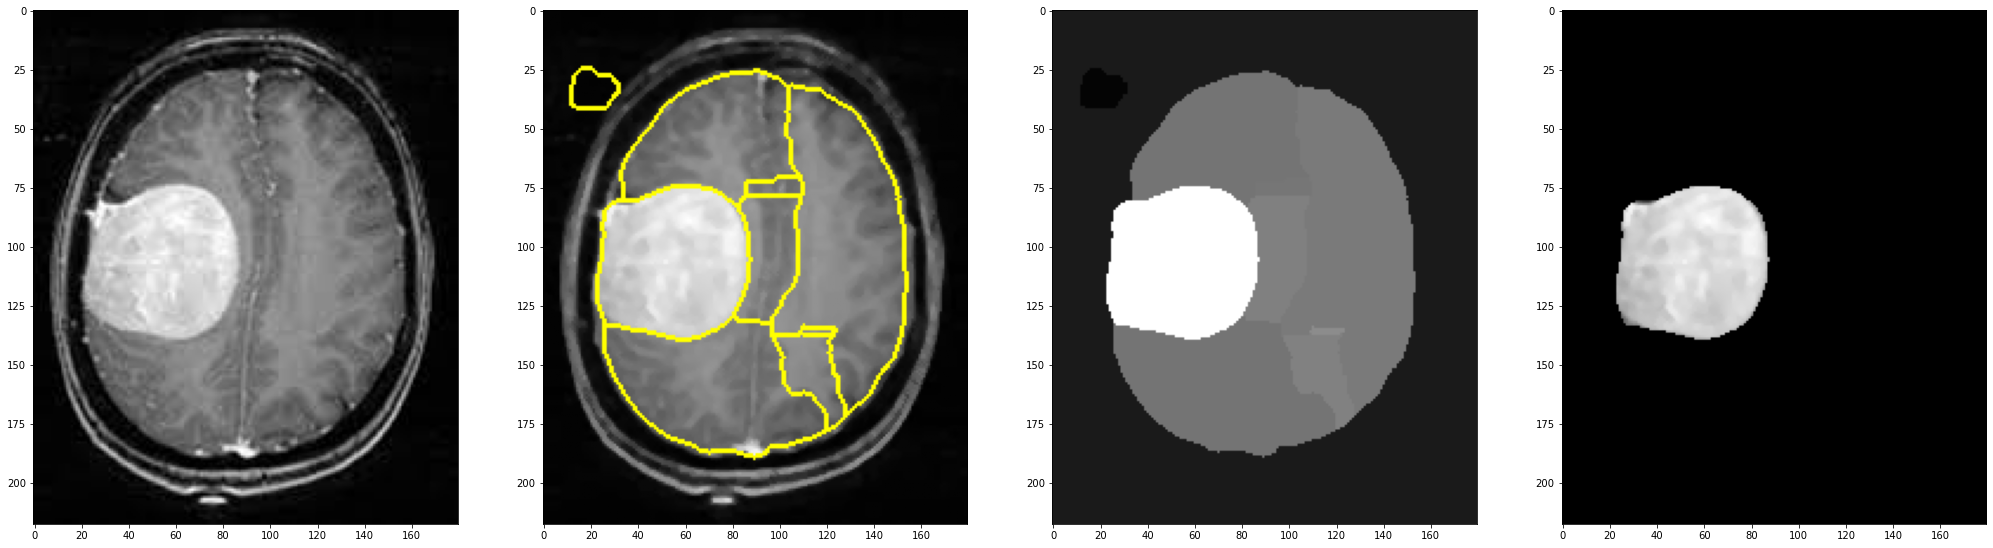

Estimation of the tumor size :  46.115575 cm²


In [3]:
from skimage.io import imread,imshow
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

im = imread('mri_brain.jpg')
original= im.copy()


#Denoise image
import skimage.filters.rank as skr
from skimage.morphology import disk
im[:,:,0] = skr.median(im[:,:,0], disk(2))
im[:,:,1] = skr.median(im[:,:,1], disk(2))
im[:,:,2] = skr.median(im[:,:,2], disk(2))


#Find markers automatically
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage.util import img_as_ubyte

def get_markers(im, indices=False):
    img_as_ubyte(im)
    im_ = gaussian(im, sigma=4, multichannel=False)
    img_as_ubyte(im_)
    gradr = rank.gradient(im_[:,:,0],disk(5)).astype('int')
    gradg = rank.gradient(im_[:,:,1],disk(5)).astype('int')
    gradb = rank.gradient(im_[:,:,2],disk(5)).astype('int')
    grad = gradr+gradg+gradb
    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=20,indices=indices),grad

markers,grad = get_markers(im, True)

#Apply watershed 
from skimage.morphology import watershed
from skimage.segmentation import mark_boundaries
from skimage.measure import label

markers, grad = get_markers(im, False)
markers = label(markers)
ws = watershed(grad, markers)


#Get descriptors for each region: 
def get_descr(region):
    return [region[:,0].mean(), region[:,1].mean(), region[:,2].mean()]
descriptors = np.zeros((ws.max()+1,3))
im_descriptors = np.zeros_like(im)
for i in range(ws.min(),ws.max()+1):
    descriptors[i] = get_descr(im[ws==i])
    im_descriptors[ws==i] = descriptors[i] 


#Extract tumor 
mask = im_descriptors[:,:,:]>200
im_descriptors[mask] = 255
tumor=im*mask


#Show results
plt.figure(figsize=(35,15))
plt.subplot(1,4,1)
plt.imshow(original)
plt.subplot(1,4,2)
plt.imshow(mark_boundaries(im,ws))
plt.subplot(1,4,3)
plt.imshow(im_descriptors)
plt.subplot(1,4,4)
plt.imshow(tumor, cmap=plt.cm.gray)
plt.show()



#Calculate surface of the tumor
counter = np.count_nonzero((im_descriptors == [255, 255, 255]).all(axis = 2))
surface = (0.115 **2) * counter
print('Estimation of the tumor size : ', surface, 'cm²')